# Complex Bayesian Network notebook

#### Import dependencies

In [54]:
# Import dependencies
%pip install pgmpy
%pip install tabulate
%pip install pandas
%pip install networkx
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


#### Load libraries

In [55]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn

## Data import and cleaning

#### Import BigPerf data

In [56]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [57]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [58]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [59]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Very Low', 'Low', 'High', 'Very-high']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 4, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Discretise data into catagories

In [60]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,Very-high,Very Low,Very Low,Very Low,Very-high,Very Low,Low,Very-high,Very Low,Very-high,Very Low,Very Low,Low
1,Very-high,Very Low,Very Low,Very Low,Very-high,Very Low,Very Low,Very Low,Low,Very Low,Very-high,Very Low,Very Low
2,Very-high,Very Low,Very Low,Very Low,High,Very Low,High,Very-high,Very Low,Very-high,Very Low,Very-high,Low
3,Very-high,Very Low,Very Low,Very Low,High,Very Low,Very Low,Very Low,Very Low,High,Very Low,Very-high,Very Low
4,Very-high,Very Low,Very Low,Very Low,High,Very Low,High,Very-high,Very Low,High,Very Low,Very-high,Low


In [61]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

## Building the model

#### Import dependencies

In [62]:
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch

#### Use structure learning to build a DAG

In [63]:
hc = HillClimbSearch(data=training_data)
estimate = hc.estimate(scoring_method='k2score')

  0%|          | 0/1000000 [00:00<?, ?it/s]

#### Generate a Bayesian Network object using the learned DAG

In [64]:
model = BayesianNetwork(estimate)

#### Fit the created BN model to the BigPerf data, in order to create probability distributions

In [65]:
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=True)

#### Plot the model as a graph

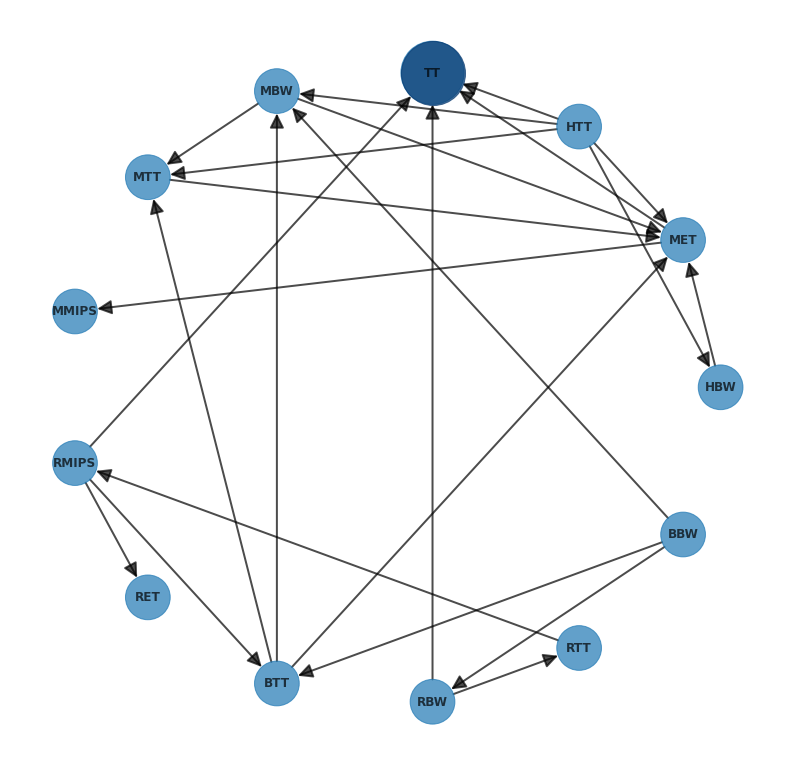

In [80]:
plt.figure(3,figsize=(14,14)) 
G = nx.DiGraph()
G.add_edges_from(model.edges)
# i = 1
# j = 1
# for node in model.nodes:
#     G.add_node(node, pos=(i, j))

#     i += 1

#     if i == 4:
#         j += 1
#         i = 1
# G.add_node('MMIPS', pos=(1, 1))
# G.add_node('MBW', pos=(2, 1))
# G.add_node('HBW', pos=(3, 1))

# G.add_node('MET', pos=(1, 2))
# G.add_node('MTT', pos=(2, 2))
# G.add_node('HTT', pos=(3, 2))

# G.add_node('BTT', pos=(1, 3))
# G.add_node('BBW', pos=(2, 3))
# G.add_node('RET', pos=(3, 3))


# G.add_node('RBW', pos=(1, 4))
# G.add_node('RTT', pos=(2, 4))
# G.add_node('RMIPS', pos=(3, 4))

# G.add_node('TT', pos=(2, 5))



# G.add_node('MMIPS', pos=(1, 3), node_size=1500)
# G.add_node('MTT', pos=(4, 5))
# G.add_node('HBW', pos=(5, 3))

# G.add_node('BTT', pos=(4, 4))
# G.add_node('MBW', pos=(2, 4))
# G.add_node('RET', pos=(7, 4))


# G.add_node('RTT', pos=(7, 3))
# G.add_node('BBW', pos=(3, 3))

# G.add_node('MET', pos=(0, 2))
# G.add_node('RBW', pos=(2, 2))
# G.add_node('HTT', pos=(4, 2))
# G.add_node('RMIPS', pos=(6, 2))

# G.add_node('TT', pos=(3, 1))


G.add_nodes_from(model.nodes)
#G.add_node(model.nodes.get('HBW'))
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)

#pos=nx.get_node_attributes(G, 'pos')

nx.draw_networkx(G,
                pos=pos,
                with_labels=True,
                node_size=[2000,2000,2000,4000,2000,2000,2000,2000,2000,2000,2000,2000,2000],
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)  # Draw the original graph

tt_g = G.subgraph(nodes=['TT'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color='#063970')

# sub_g = G.subgraph(nodes=['MET', 'HTT', 'RBW', 'RMIPS'])
# nx.draw(sub_g, pos=pos, with_labels=False, arrowsize=0, node_size=1400, alpha=0.7, font_weight="bold", node_color='#FFA500')  # Draw the original graph


plt.show()

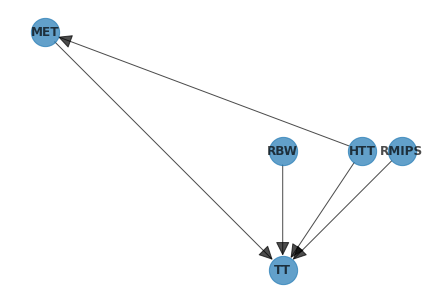

In [38]:
sub_g = G.subgraph(nodes=['MET', 'HTT', 'RBW', 'RMIPS', 'TT'])
nx.draw(sub_g, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

In [39]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

accuracy_dict = {}

for column in testing_data:
    predict_data = testing_data.copy()
    predict_data.drop(column, axis=1, inplace=True)
    y_pred = model.predict(predict_data)

    accuracy = accuracy_score(testing_data[column], y_pred)
    
    # if len(testing_data[column].unique()) == 2:
    #     precision = precision_score(testing_data[column], y_pred, pos_label='High') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, pos_label='High')
    #     recall = recall_score(testing_data[column], y_pred, pos_label='High')

    # else:
    #     precision = precision_score(testing_data[column], y_pred, average='micro') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, average='micro')
    #     recall = recall_score(testing_data[column], y_pred, average='micro')

    #print(f'{column} F1 score: {f1}')
    print(f'{column} Accuracy score: {accuracy}')

    accuracy_dict[column] = accuracy
    #print(f'{column} Precision score: {precision}')
    #print(f'{column} Recall score: {recall}')

  0%|          | 0/150 [00:00<?, ?it/s]

HBW Accuracy score: 0.9940944881889764


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/152 [00:00<?, ?it/s]

HTT Accuracy score: 0.9901574803149606


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MMIPS Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/138 [00:00<?, ?it/s]

MBW Accuracy score: 0.9311023622047244


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/101 [00:00<?, ?it/s]

MTT Accuracy score: 0.75


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/134 [00:00<?, ?it/s]

RMIPS Accuracy score: 0.8917322834645669


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/141 [00:00<?, ?it/s]

RTT Accuracy score: 0.8996062992125984


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BTT Accuracy score: 0.9980314960629921


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/137 [00:00<?, ?it/s]

TT Accuracy score: 0.889763779527559


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


## Scoring the model

#### Run scoring functions on the model to collect metrics of correctness

In [40]:
f1 = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=testing_data)
ss = structure_score(model=model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Structure score: {ss}')

print(model.name)

F1 score: 0.6153846153846153
Accuracy score: 0.8076923076923077
Precision score: 1.0
Recall score: 0.4444444444444444
Log-likilihood score: -2558.340124235847
Structure score: -2998.720964135828



In [41]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score, accuracy_dict):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    conv_dict = {}
    for k, v in accuracy_dict.items():
        conv_dict[k] = v*100
    
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score,
    'HBW prediction accuracy': conv_dict['HBW'], 'HTT prediction accuracy': conv_dict['HTT'], 'MMIPS prediction accuracy': conv_dict['MMIPS'], 'MET prediction accuracy': conv_dict['MET'],
    'MBW prediction accuracy': conv_dict['MBW'], 'MTT prediction accuracy': conv_dict['MTT'], 'RMIPS prediction accuracy': conv_dict['RMIPS'], 'RET prediction accuracy': conv_dict['RET'],
    'RBW prediction accuracy': conv_dict['RBW'], 'RTT prediction accuracy': conv_dict['RTT'], 'BBW prediction accuracy': conv_dict['BBW'], 'BTT prediction accuracy': conv_dict['BTT'],
    'TT prediction accuracy': conv_dict['TT']}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)

In [42]:
model_name = 'Score-based CBN'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss, accuracy_dict=accuracy_dict)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_20944/2438977843.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [43]:
# Initializing the VariableElimination class

from pgmpy.inference import VariableElimination
from pgmpy.inference.ExactInference import BeliefPropagation

bigPerf_infer = BeliefPropagation(model=model)

In [44]:
# Compute probabilities of parent variables of TT when TT is Very Low
q_tt = bigPerf_infer.query(variables=['HTT', 'MET', 'RBW', 'RMIPS'], evidence={'TT': 'Very Low'}, joint=False)

#print(query)
for factor in q_tt.values():
    print(factor)

  0%|          | 0/8 [00:00<?, ?it/s]

+----------------+------------+
| HTT            |   phi(HTT) |
+================+============+
| HTT(Very Low)  |     0.8370 |
+----------------+------------+
| HTT(Very-high) |     0.1630 |
+----------------+------------+
+----------------+------------+
| MET            |   phi(MET) |
+================+============+
| MET(High)      |     0.0797 |
+----------------+------------+
| MET(Low)       |     0.2472 |
+----------------+------------+
| MET(Very Low)  |     0.6711 |
+----------------+------------+
| MET(Very-high) |     0.0020 |
+----------------+------------+
+----------------+------------+
| RBW            |   phi(RBW) |
+================+============+
| RBW(Low)       |     0.5747 |
+----------------+------------+
| RBW(Very Low)  |     0.1000 |
+----------------+------------+
| RBW(Very-high) |     0.3253 |
+----------------+------------+
+------------------+--------------+
| RMIPS            |   phi(RMIPS) |
+==================+==============+
| RMIPS(High)      |       0

In [45]:
q_ret = bigPerf_infer.query(variables=['RMIPS'], evidence={'RET': 'Very Low'}, joint=False)

#print(query)
for factor in q_ret.values():
    print(factor)

  0%|          | 0/11 [00:00<?, ?it/s]

+------------------+--------------+
| RMIPS            |   phi(RMIPS) |
+==================+==============+
| RMIPS(High)      |       0.0006 |
+------------------+--------------+
| RMIPS(Low)       |       0.0006 |
+------------------+--------------+
| RMIPS(Very Low)  |       0.9982 |
+------------------+--------------+
| RMIPS(Very-high) |       0.0006 |
+------------------+--------------+


In [46]:
q_met = bigPerf_infer.query(variables=['MMIPS', 'MTT', 'HBW', 'MBW', 'HTT', 'BTT'], evidence={'MET': 'Very Low'}, joint=False)

for factor in q_met.values():
    print(factor)

  0%|          | 0/6 [00:00<?, ?it/s]

+----------+--------------+
| MMIPS    |   phi(MMIPS) |
+==========+==============+
| MMIPS(0) |       0.0006 |
+----------+--------------+
| MMIPS(1) |       0.0006 |
+----------+--------------+
| MMIPS(2) |       0.9982 |
+----------+--------------+
| MMIPS(3) |       0.0006 |
+----------+--------------+
+--------+------------+
| MTT    |   phi(MTT) |
+========+============+
| MTT(0) |     0.4840 |
+--------+------------+
| MTT(1) |     0.1668 |
+--------+------------+
| MTT(2) |     0.2279 |
+--------+------------+
| MTT(3) |     0.1212 |
+--------+------------+
+--------+------------+
| HBW    |   phi(HBW) |
+========+============+
| HBW(0) |     0.5532 |
+--------+------------+
| HBW(1) |     0.4468 |
+--------+------------+
+----------------+------------+
| MBW            |   phi(MBW) |
+================+============+
| MBW(High)      |     0.0444 |
+----------------+------------+
| MBW(Low)       |     0.0177 |
+----------------+------------+
| MBW(Very Low)  |     0.8385 |
+---

#### Print the model's probability distributions

In [47]:
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of HBW:
+----------------+----------------------+----------------------+
| HTT            | HTT(Very Low)        | HTT(Very-high)       |
+----------------+----------------------+----------------------+
| HBW(Very Low)  | 0.014260640631856078 | 0.9986072423398329   |
+----------------+----------------------+----------------------+
| HBW(Very-high) | 0.9857393593681439   | 0.001392757660167131 |
+----------------+----------------------+----------------------+ 

CPT of HTT:
+----------------+----------+
| HTT(Very Low)  | 0.559401 |
+----------------+----------+
| HTT(Very-high) | 0.440599 |
+----------------+----------+ 

CPT of MMIPS:
+------------------+-----+-----------------------+
| MET              | ... | MET(Very-high)        |
+------------------+-----+-----------------------+
| MMIPS(High)      | ... | 0.0005558025789239662 |
+------------------+-----+-----------------------+
| MMIPS(Low)       | ... | 0.0005558025789239662 |
+------------------+-----+--